## Import packages and define parameters

In [30]:
# Import packages
from pkasolver import data
from pkasolver import chem
from pkasolver import ml
from pkasolver import stat
from pkasolver import constants as c

import pickle
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import sys
import random
random.seed(42)

#Import Torch packages
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU, ModuleList
from torch_geometric.nn import GCNConv, NNConv, BatchNorm, global_max_pool
from torch import optim
from captum.attr import IntegratedGradients

In [32]:
# Config Parameters
LOAD_MODEL = False
LOAD_DATA = True
LOAD_TESTSETS = True
CHECKPOINT_PATH = 'saved_models/current/'
CROSS_VAL = True
CROSS_VAL_NUM = 0
# CROSS_VAL_NUM = sys.argv[1]
if CROSS_VAL:
    CHECKPOINT_PATH = CHECKPOINT_PATH + f'cv{CROSS_VAL_NUM}_'
CHECKPOINT_NAME = 'checkpoint_ep0.pth.tar'


In [3]:
#Hyperparameters
if LOAD_MODEL:
    #load checkpoint 
    checkpoint = torch.load(f'modelsaves/1#/{CHECKPOINT_NAME}')
    TRAIN_TEST_SPLIT = checkpoint['train_test_split']
    BATCH_SIZE = checkpoint['batch_size']
    LEARNING_RATE = checkpoint['learning_rate']
    NUM_EPOCHS = checkpoint['num_epochs']
    DEVICE = checkpoint['device']
    PAIRED = checkpoint['paired']
    NUM_GRAPH_LAYERS = checkpoint['num_graph_layers']
    NUM_LINEAR_LAYERS = checkpoint['num_linear_layers']
    HIDDEN_CHANNELS = checkpoint['hidden_channels']
    NODE_FEATURES = checkpoint['node_features']
    EDGE_FEATURES = checkpoint['edge_features']
    best_loss = checkpoint['best_loss']
    
    print(checkpoint['progress'])

    
else:
    TRAIN_TEST_SPLIT = 0.8
    BATCH_SIZE = 64
    LEARNING_RATE =0.001
    NUM_EPOCHS = 40000
    DEVICE="cpu"
    PAIRED = False
    NUM_GRAPH_LAYERS = 3
    NUM_LINEAR_LAYERS = 2
    HIDDEN_CHANNELS = 96
    best_loss=2

    NODE_FEATURES = [
        'atomic_number',
        'formal_charge',
        'chiral_tag',
        'hybridization',
        'explicit_Hs_number',
        'aromatic_tag',
        'total_valence',
        'total_degree'
    ]

    EDGE_FEATURES = [
        'bond_type',
        'is_conjugated'
    ]

num_node_features = len(NODE_FEATURES)
num_edge_features = len(EDGE_FEATURES)

In [4]:
def convs():
    if num_edge_features > 0:
        nn = Seq(Linear(num_edge_features, 16), ReLU(), Linear(16, num_node_features*HIDDEN_CHANNELS))
        nn1 = Seq(Linear(num_edge_features, 16), ReLU(), Linear(16, HIDDEN_CHANNELS* HIDDEN_CHANNELS))
        convs = ModuleList([NNConv(num_node_features, HIDDEN_CHANNELS, nn=nn)])
        convs.extend([NNConv(HIDDEN_CHANNELS, HIDDEN_CHANNELS, nn=nn1) for i in range(NUM_GRAPH_LAYERS-1)])
    else:
        convs = ModuleList([GCNConv(num_node_features, HIDDEN_CHANNELS)])
        convs.extend([GCNConv(HIDDEN_CHANNELS, HIDDEN_CHANNELS) for i in range(NUM_GRAPH_LAYERS-1)])
    return convs

def lins():
    channels= HIDDEN_CHANNELS
    if PAIRED:
        channels= HIDDEN_CHANNELS*2
    lins= ModuleList([Linear(channels, channels) for i in range(NUM_LINEAR_LAYERS-1)])
    lins.extend([Linear(channels, 1)])
    return lins


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(1)

        self.convs_x = convs()
        if PAIRED:
            self.convs_x2 = convs()
        self.lin = lins()
    
    def forward_helper(self, x, x2, edge_attr, edge_attr2, data):
        
        if num_edge_features:
            for i in range(len(self.convs_x)):
                x = self.convs_x[i](x, data.edge_index, edge_attr)
                x = x.relu()
            if PAIRED:
                for i in range(len(self.convs_x2)):
                    x2 = self.convs_x2[i](x2, data.edge_index2, edge_attr2)
                    x2 = x2.relu()
                
        else:
            for i in range(len(self.convs_x)):
                x = self.convs_x[i](x, data.edge_index)
                x = x.relu()
            if PAIRED:
                for i in range(len(self.convs_x2)):
                    x2 = self.convs_x2[i](x2, data.edge_index2)
                    x2 = x2.relu()

        # 2. Readout layer
        x = global_max_pool(x, data.batch.to(device=DEVICE))  # [batch_size, hidden_channels]
        if PAIRED: 
            x2 = global_max_pool(x2, data.x2_batch.to(device=DEVICE))
            
        if PAIRED:
            x = torch.cat((x, x2), 1)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        for i in range(len(self.lin)):
                x = self.lin[i](x)
        return x
    
    if PAIRED:
        def forward(self, x, x2, edge_attr, edge_attr2, data):
            return self.forward_helper(x, x2, edge_attr, edge_attr2, data)
    else:
        def forward(self, x, edge_attr, x2, edge_attr2, data):
            return self.forward_helper(x, x2, edge_attr, edge_attr2, data)

In [5]:
# Load dict of DataFrames
if LOAD_DATA:
    with open('data/pd_all_datasets.pkl', 'rb') as pickle_file:
        pd_dataset = pickle.load(pickle_file)
else:
    PATH = "../data/Baltruschat/"
    SDF_TRAINING = "combined_training_datasets_unique.sdf"
    SDF_NOVARTIS = "novartis_cleaned_mono_unique_notraindata.sdf"
    SDF_LITERATURE = "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"

    datasets = {
        "Training": PATH+SDF_TRAINING,
        "Novartis": PATH+SDF_NOVARTIS,
        "AvLiLuMoVe": PATH+SDF_LITERATURE,
    }

    pd_datasets = data.preprocess_all(datasets, title='pd_all_datasets')
    with open(f'data/pd_all_datasets.pkl', 'wb') as pickle_file:
            pickle.dump(pd_datasets,pickle_file)

# make pyG Dataset form 'Training'- Dataset    
dataset = data.make_pyg_dataset(pd_dataset['Training'], NODE_FEATURES, EDGE_FEATURES, paired=True)
random.shuffle(dataset)

if CROSS_VAL:
    train_data, val_data = data.cross_val_lists(data.slice_list(dataset,10),CROSS_VAL_NUM)
else:
    train_data, val_data = ml.pyg_split(dataset, TRAIN_TEST_SPLIT)

train_loader = ml.dataset_to_dataloader(train_data, BATCH_SIZE)
val_loader = ml.dataset_to_dataloader(val_data, BATCH_SIZE)

if LOAD_TESTSETS:
    dataset_nov = data.make_pyg_dataset(pd_dataset['Novartis'], NODE_FEATURES, EDGE_FEATURES, paired=True)
    dataset_avli = data.make_pyg_dataset(pd_dataset['AvLiLuMoVe'], NODE_FEATURES, EDGE_FEATURES, paired=True)
    nov_loader = ml.dataset_to_dataloader(dataset_nov, BATCH_SIZE)
    avli_loader = ml.dataset_to_dataloader(dataset_avli, BATCH_SIZE)

## Define model class

In [39]:
# Create Single model
model = GCN().to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()
criterion_v = torch.nn.L1Loss() # that's the MAE Loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

print(model)
if LOAD_MODEL:
    train_data =data.load_data(dataset, checkpoint['training_data'])
    val_data =data.load_data(dataset, checkpoint['val_data'])
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()
else:
    # Save first checkpoint
    checkpoint = {
        'epoch': 0,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_data': [train_data[i].ID for i in range(len(train_data))],
        'val_data': [val_data[i].ID for i in range(len(val_data))],
        'node_features': NODE_FEATURES,
        'edge_features': EDGE_FEATURES,
        'progress':'',
        'train_test_split': TRAIN_TEST_SPLIT,
        'num_epochs': NUM_EPOCHS,
        'device': DEVICE,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'paired': PAIRED,
        'num_graph_layers': NUM_GRAPH_LAYERS,
        'num_linear_layers': NUM_LINEAR_LAYERS,
        'hidden_channels': HIDDEN_CHANNELS,
        'best_loss': best_loss
    }
    torch.save(checkpoint,f'{CHECKPOINT_PATH}checkpoint_ep0.pth.tar')
    
    config_dict = {'key':'value',
                   'batch_size': BATCH_SIZE,
                   'paired': PAIRED,
                   'num_graph_layers': NUM_GRAPH_LAYERS,
                   'num_linear_layers': NUM_LINEAR_LAYERS,
                   'hidden_channels': HIDDEN_CHANNELS,
                   'node_features': NODE_FEATURES,
                   'edge_features': EDGE_FEATURES
                  }
    
    # open the file in the write mode
    with open(CHECKPOINT_PATH + 'config.csv', 'w') as f:
        # create the csv writer
        writer = csv.writer(f)
        for key, val in config_dict.items():
            writer.writerow([key, val])

GCN(
  (convs_x): ModuleList(
    (0): NNConv(8, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=1, bias=True)
  )
)


In [7]:
def train(loader):
    model.train()
    for data in loader:  # Iterate in batches over the training dataset. 
        out = model(x=data.x, x2=data.x2,edge_attr=data.edge_attr, edge_attr2=data.edge_attr2, data=data)
        loss = criterion(out.flatten(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        
def test(loader):
    model.eval()
    loss = torch.Tensor([0]).to(device=DEVICE)
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(x=data.x, x2=data.x2,edge_attr=data.edge_attr, edge_attr2=data.edge_attr2, data=data)  # Perform a single forward pass.
        loss += criterion_v(out.flatten(), data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches

def save_checkpoint(checkpoint, epoch, model, optimizer, update, best_loss, is_best):
    checkpoint['epoch']=epoch+1
    checkpoint['model_state_dict']=model.state_dict()
    checkpoint['optimizer_state']=optimizer.state_dict()
    checkpoint['progress']+= update + '\n'
    checkpoint['best_loss']=best_loss
    print('Saving checkpoint...')
    filename=f'{CHECKPOINT_PATH}checkpoint_ep{epoch}.pth.tar'
    torch.save(checkpoint, filename)
    if is_best:
        shutil.copyfile(filename, f'{CHECKPOINT_PATH}model_best.pth.tar')
    print('done')
    return checkpoint

In [9]:
for epoch in range(checkpoint['epoch'], NUM_EPOCHS):
    checkpoint['epoch'] = epoch+1
    if epoch != 0: 
        train(train_loader)
    if epoch % 50 == 0:
        train_acc = test(train_loader)
        test_acc = test(val_loader)
        update = f'Epoch: {epoch:03d}, Train MAE: {train_acc.item():.4f}, Test MAE: {test_acc.item():.4f}'
        print(update)
    if epoch % 100 ==0:
        is_best = train_acc < best_loss
        best_loss = min(train_acc, best_loss)
        checkpoint = save_checkpoint(checkpoint, epoch, model, optimizer, update, best_loss, is_best)

Epoch: 002, Train MAE: 1.9651, Test MAE: 2.0354
Epoch: 004, Train MAE: 1.8430, Test MAE: 1.8913
Epoch: 006, Train MAE: 1.7446, Test MAE: 1.7792
Epoch: 008, Train MAE: 1.6392, Test MAE: 1.6728
Epoch: 010, Train MAE: 1.5834, Test MAE: 1.6067
Epoch: 012, Train MAE: 1.5372, Test MAE: 1.5467
Epoch: 014, Train MAE: 1.4906, Test MAE: 1.5260
Epoch: 016, Train MAE: 1.4146, Test MAE: 1.4434
Epoch: 018, Train MAE: 1.3843, Test MAE: 1.4252
Epoch: 020, Train MAE: 1.3293, Test MAE: 1.3635
Epoch: 022, Train MAE: 1.3144, Test MAE: 1.3569
Epoch: 024, Train MAE: 1.3105, Test MAE: 1.3382
Epoch: 026, Train MAE: 1.2704, Test MAE: 1.3046
Epoch: 028, Train MAE: 1.2535, Test MAE: 1.2795
Epoch: 030, Train MAE: 1.2615, Test MAE: 1.2881
Epoch: 032, Train MAE: 1.2654, Test MAE: 1.3066
Epoch: 034, Train MAE: 1.2495, Test MAE: 1.2808
Epoch: 036, Train MAE: 1.2451, Test MAE: 1.2746


KeyboardInterrupt: 

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def f(x):
    d = {}
    d['r2_score'] = r2_score(x['pKa_experimental'],x['pKa_predicted'])
    d['MAE'] = mean_absolute_error(x['pKa_experimental'],x['pKa_predicted'])
    d['RMSE'] = np.sqrt(mean_squared_error(x['pKa_experimental'],x['pKa_predicted']))
    return pd.Series(d, index=['r2_score', 'MAE', 'RMSE']).round(3)

df=pd.concat([stat.test_model(model, val_loader,'Validation_set'),
         stat.test_model(model, nov_loader,'Novartis_set'),
         stat.test_model(model, avli_loader,'Literature_set')])

df.groupby('Dataset').apply(f)

,r2_score,MAE,RMSE
Dataset,,,
Literature_set,0.700,1.007,1.292
Novartis_set,0.484,1.324,1.654
Validation_set,0.574,1.311,1.629


In [16]:
ig = IntegratedGradients(model)
attr_df = stat.calc_importances(ig, dataset, 10, NODE_FEATURES, EDGE_FEATURES, PAIRED)

1 of 10
6 of 10
632


In [17]:
attr_df

,ID,atomic_number,formal_charge,chiral_tag,hybridization,explicit_Hs_number,aromatic_tag,total_valence,total_degree,bond_type,is_conjugated
0,2148363,-0.029151,-0.0,0.0,0.283518,0.0,0.000000,0.163644,0.320776,0.000000,0.000000
1,2148363,-0.530188,-0.0,-0.0,0.144388,0.0,-0.000000,-0.038110,0.091675,0.000000,0.000000
2,2148363,0.002073,0.0,0.0,0.005784,0.0,0.002670,0.037524,-0.000931,0.000000,0.000000
3,2148363,0.110416,-0.0,0.0,0.172203,0.0,-0.153126,0.069951,-0.263993,0.000000,0.000000
4,2148363,0.057254,0.0,0.0,0.423928,0.0,-0.053904,0.105025,-0.075245,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
627,6952,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.051381,0.041121
628,6952,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.097347,0.006570
629,6952,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
630,6952,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,-0.121039,0.083870


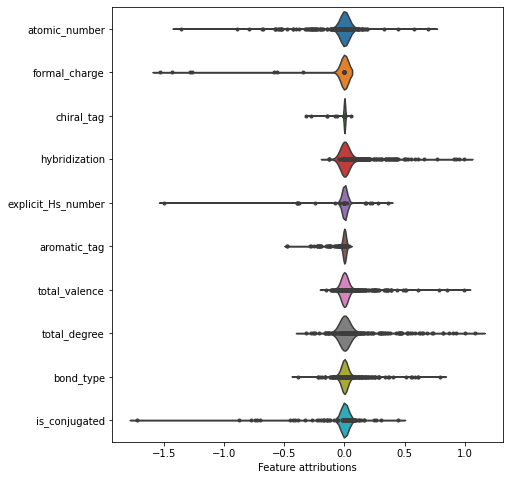

In [18]:
## sns.set_context('talk')
f, ax = plt.subplots(figsize=(7, 8))
sns.violinplot(y="variable", x="value", data=pd.melt(attr_df.drop(['ID'], axis=1)),inner="points", scale='count')
ax.set(xlabel='Feature attributions', ylabel='')
plt.show()

In [20]:
f = open("dict.txt","w")
f.write( str(checkpoint) )
f.close()